In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.layers.merge import concatenate
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.layers import Input
from sklearn.model_selection import KFold
from keras.layers.pooling import AveragePooling1D
from keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Convolution1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.initializers import random_uniform
from keras.layers import LSTM
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
df_TFIDF40 = pd.read_csv('/content/drive/MyDrive/Experiments HealthML CNN/input_ICD9_TFIDF_40.csv') # loading updated csv
df_TFIDF40.rename(columns={'Label': 'ICD9'}, inplace=True)
df_TM5 = pd.read_csv('/content/drive/MyDrive/Experiments HealthML CNN/input_ICD9_TM_5.csv')
df_TM20 = pd.read_csv('/content/drive/MyDrive/Experiments HealthML CNN/input_ICD9_TM_20.csv')
df_TM30 = pd.read_csv('/content/drive/MyDrive/Experiments HealthML CNN/input_ICD9_TM_30.csv')
df_TM30.rename(columns={'top_icd': 'ICD9'}, inplace=True)
df_TM39 = pd.read_csv('/content/drive/MyDrive/Experiments HealthML CNN/input_ICD9_TM_39.csv')

df_list = [df_TFIDF40, df_TM5, df_TM20, df_TM30, df_TM39]
files_list = ['TFIDF_40', 'TM_5', 'TM_20', 'TM_30', 'TM_39']

In [ ]:
df_TFIDF40_old = pd.read_csv('/content/drive/MyDrive/Experiments HealthML CNN/input_ICD9_TFIDF_40.csv')

In [ ]:
df_TM20.head(4)

,ICD9,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19
0,424,0.075826,0.035514,0.093239,0.038146,0.015947,0.113980,0.053861,0.027136,0.028813,0.107879,0.038639,0.068352,0.103821,0.000000,0.026953,0.0,0.019094,0.114964,0.012817,0.015217
1,410,0.000000,0.018039,0.016154,0.017364,0.000000,0.015514,0.000000,0.227861,0.018801,0.000000,0.013507,0.262186,0.000000,0.000000,0.000000,0.0,0.059638,0.086761,0.186939,0.048626
2,414,0.000000,0.000000,0.026252,0.031915,0.032926,0.095679,0.011797,0.014570,0.142651,0.010267,0.115032,0.160490,0.000000,0.000000,0.000000,0.0,0.000000,0.015606,0.305903,0.014871
3,410,0.000000,0.020312,0.010860,0.057352,0.037957,0.042617,0.040979,0.078233,0.110078,0.028450,0.000000,0.312919,0.032175,0.023174,0.000000,0.0,0.039586,0.038681,0.096131,0.012925


In [ ]:
print([True for df in df_list if 'ICD9' in df.columns])
print([df.shape for df in df_list]) # correct shapes

[True, True, True, True, True]
[(5936, 41), (11537, 6), (11537, 21), (11537, 31), (11537, 40)]


In [ ]:
print([True for df in df_list if 'ICD9' in df.columns])
print([df.shape for df in df_list])
print([df['ICD9'].value_counts() for df in df_list], end= "\n")

[True, True, True, True, True]
[(5936, 41), (11537, 6), (11537, 21), (11537, 31), (11537, 40)]
[414    1792
38     1654
410    1605
424     885
Name: ICD9, dtype: int64, 414    3502
38     3184
410    3175
424    1676
Name: ICD9, dtype: int64, 414    3502
38     3184
410    3175
424    1676
Name: ICD9, dtype: int64, 414    3502
38     3184
410    3175
424    1676
Name: ICD9, dtype: int64, 414    3502
38     3184
410    3175
424    1676
Name: ICD9, dtype: int64]


In [ ]:
def get_data(df:pd.DataFrame):
 
  ICD9_CODE_map = {
    '414': 0, #chronic heart
    '38':  1, #sepsis
    '410': 2, #heart attack
    '424': 3, #diseases of endocardium
    }
  Y = df.ICD9
  X = df.drop(columns=['ICD9'])
  Y = Y.map({414:0, 38: 1, 410:2, 424: 3})
  Y = to_categorical(Y, 4)
  X = X.values.astype('float')
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state = 42, shuffle=True) 
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X_train, X_test, Y_train, Y_test

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
def print_evaluation_scores(y_val, predicted):
    print('Accuracy score: ', accuracy_score(y_val, predicted))
    print('F1 score: ', f1_score(y_val, predicted, average='micro'))
    print('Average precision score: ', precision_score(y_val, predicted, average='micro'))
    print('Average recall score: ', recall_score(y_val, predicted, average='micro'))

In [ ]:
# # Original works well with all TMs
def cnn(df:pd.DataFrame, DataName: str):
		print(DataName, ":", df.shape)
		X_train, X_test, Y_train, Y_test = get_data(df)
		model = Sequential()
		model.add(Conv1D(32, 3, activation='relu', input_shape = (X_train.shape[1],1)))
		model.add(BatchNormalization()) 
		model.add(Dropout(0.5)) 
		model.add(MaxPooling1D(2))
		model.add(Flatten())
		model.add(Dense(100, activation='relu'))
		model.add(Dense(4, activation='softmax'))
		model.compile(loss="categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

		history = model.fit(X_train, Y_train,validation_split=0.25, epochs = 25, batch_size=32, shuffle=True, verbose=1)  
		predictions = model.predict(X_test)
		Y_pred = predictions.argmax(axis=1)
		Y_test_max = Y_test.argmax(axis=1)
		accuracy = accuracy_score(Y_test_max, Y_pred)
		bal_acc = balanced_accuracy_score(Y_test_max, Y_pred)
		recall =  recall_score(Y_test_max, Y_pred, average='micro')
		f1_weighted = f1_score(Y_test_max, Y_pred, average='weighted')
		f1_average = f1_score(Y_test_max, Y_pred, average='micro')
		precision = precision_score(Y_test_max, Y_pred, average='micro')
		auc = roc_auc_score(Y_test_max, predictions, multi_class='ovr', average='macro')
		results = dict()
		results['accuracy'] = accuracy
		results['bal_acc'] = bal_acc
		results['f1_weighted'] = f1_weighted
		results['f1_average'] = f1_average
		results['auc'] = auc
		results['recall'] = recall
		results['precision'] = precision

		plt.plot(history.history['accuracy'])
		plt.plot(history.history['val_accuracy'])
		plt.title('Model Accuracy for %s' % DataName)
		plt.ylabel('Accuracy')
		plt.xlabel('Epoch')
		plt.legend(['train', 'val'], loc='upper left')
		plt.show()
		plt.plot(history.history['loss'])
		plt.plot(history.history['val_loss'])
		plt.title('Model loss for %s' % DataName)
		plt.ylabel('loss')
		plt.xlabel('epoch')
		plt.legend(['train', 'val'], loc='upper left')
		plt.show()
		return results

In [ ]:
lst = ['TFIDF_40', 'TM_5', 'TM_20', 'TM_30', 'TM_39']

TFIDF_40 : (5936, 41)
Epoch 1/25
94/94 [==============================] - 2s 9ms/step - loss: 0.7292 - accuracy: 0.7203 - val_loss: 1.2234 - val_accuracy: 0.3809
Epoch 2/25
94/94 [==============================] - 1s 8ms/step - loss: 0.5371 - accuracy: 0.7931 - val_loss: 1.1478 - val_accuracy: 0.4533
Epoch 3/25
94/94 [==============================] - 1s 7ms/step - loss: 0.5132 - accuracy: 0.8068 - val_loss: 1.0110 - val_accuracy: 0.6332
Epoch 4/25
94/94 [==============================] - 1s 7ms/step - loss: 0.5076 - accuracy: 0.8042 - val_loss: 0.8435 - val_accuracy: 0.7920
Epoch 5/25
94/94 [==============================] - 1s 7ms/step - loss: 0.4935 - accuracy: 0.8052 - val_loss: 0.7221 - val_accuracy: 0.7869
Epoch 6/25
94/94 [==============================] - 1s 7ms/step - loss: 0.4617 - accuracy: 0.8233 - val_loss: 0.5347 - val_accuracy: 0.8211
Epoch 7/25
94/94 [==============================] - 1s 7ms/step - loss: 0.4616 - accuracy: 0.8189 - val_loss: 0.4812 - val_accuracy: 0.828

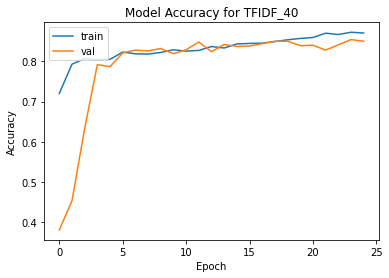

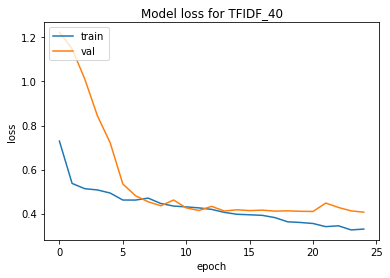

TM_5 : (11537, 6)
Epoch 1/25
182/182 [==============================] - 2s 8ms/step - loss: 0.9105 - accuracy: 0.6178 - val_loss: 1.0523 - val_accuracy: 0.6280
Epoch 2/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7819 - accuracy: 0.6555 - val_loss: 0.8658 - val_accuracy: 0.6622
Epoch 3/25
182/182 [==============================] - 1s 6ms/step - loss: 0.7671 - accuracy: 0.6613 - val_loss: 0.7545 - val_accuracy: 0.6679
Epoch 4/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7586 - accuracy: 0.6737 - val_loss: 0.7297 - val_accuracy: 0.6710
Epoch 5/25
182/182 [==============================] - 1s 6ms/step - loss: 0.7555 - accuracy: 0.6627 - val_loss: 0.7330 - val_accuracy: 0.6834
Epoch 6/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7549 - accuracy: 0.6637 - val_loss: 0.7433 - val_accuracy: 0.6637
Epoch 7/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7451 - accuracy: 0.6727 - val_loss: 0.7447 - val_accur

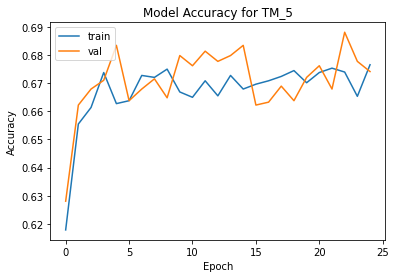

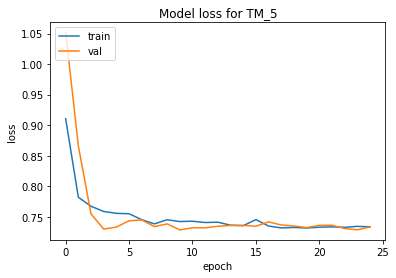

TM_20 : (11537, 21)
Epoch 1/25
182/182 [==============================] - 2s 8ms/step - loss: 0.8417 - accuracy: 0.6470 - val_loss: 1.2238 - val_accuracy: 0.6756
Epoch 2/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7236 - accuracy: 0.6991 - val_loss: 1.0176 - val_accuracy: 0.7124
Epoch 3/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7011 - accuracy: 0.7131 - val_loss: 0.7743 - val_accuracy: 0.7253
Epoch 4/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6827 - accuracy: 0.7202 - val_loss: 0.6730 - val_accuracy: 0.7310
Epoch 5/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6752 - accuracy: 0.7255 - val_loss: 0.6649 - val_accuracy: 0.7217
Epoch 6/25
182/182 [==============================] - 1s 6ms/step - loss: 0.6663 - accuracy: 0.7210 - val_loss: 0.6562 - val_accuracy: 0.7362
Epoch 7/25
182/182 [==============================] - 1s 6ms/step - loss: 0.6673 - accuracy: 0.7258 - val_loss: 0.6681 - val_acc

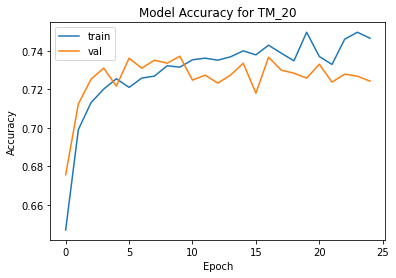

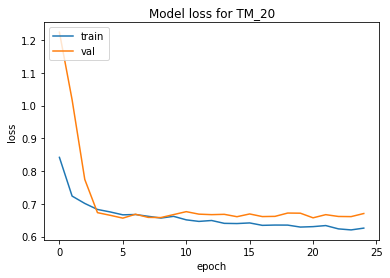

TM_30 : (11537, 31)
Epoch 1/25
182/182 [==============================] - 2s 9ms/step - loss: 0.7944 - accuracy: 0.6713 - val_loss: 1.2183 - val_accuracy: 0.5406
Epoch 2/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6939 - accuracy: 0.7186 - val_loss: 1.0157 - val_accuracy: 0.7196
Epoch 3/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6834 - accuracy: 0.7238 - val_loss: 0.7881 - val_accuracy: 0.7346
Epoch 4/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6790 - accuracy: 0.7210 - val_loss: 0.6510 - val_accuracy: 0.7356
Epoch 5/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6707 - accuracy: 0.7239 - val_loss: 0.6513 - val_accuracy: 0.7356
Epoch 6/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6580 - accuracy: 0.7267 - val_loss: 0.6462 - val_accuracy: 0.7356
Epoch 7/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6512 - accuracy: 0.7322 - val_loss: 0.6398 - val_acc

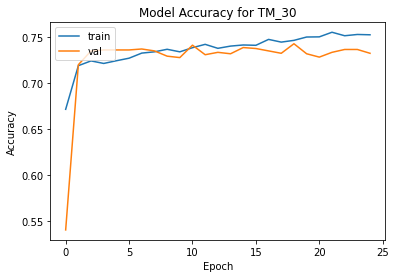

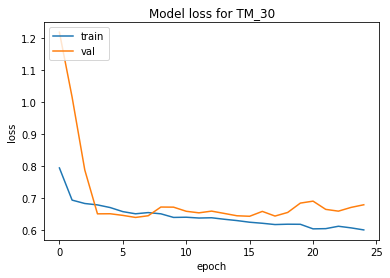

TM_39 : (11537, 40)
Epoch 1/25
182/182 [==============================] - 2s 8ms/step - loss: 0.8539 - accuracy: 0.6491 - val_loss: 1.2929 - val_accuracy: 0.2814
Epoch 2/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7250 - accuracy: 0.7088 - val_loss: 1.1585 - val_accuracy: 0.4232
Epoch 3/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7010 - accuracy: 0.7077 - val_loss: 0.8335 - val_accuracy: 0.6694
Epoch 4/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7005 - accuracy: 0.7134 - val_loss: 0.6940 - val_accuracy: 0.7201
Epoch 5/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6900 - accuracy: 0.7169 - val_loss: 0.7083 - val_accuracy: 0.7134
Epoch 6/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6812 - accuracy: 0.7177 - val_loss: 0.6611 - val_accuracy: 0.7274
Epoch 7/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6817 - accuracy: 0.7265 - val_loss: 0.6687 - val_acc

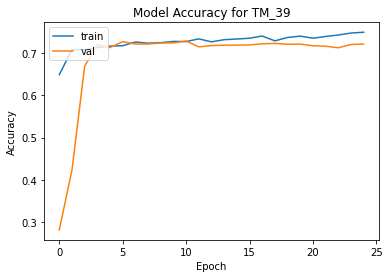

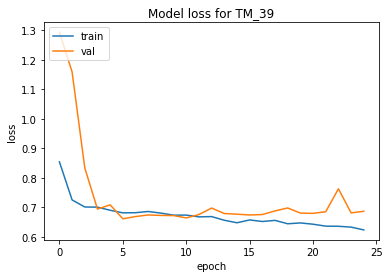

In [ ]:
results = [cnn(df, lst[i]) for i, df in enumerate(df_list)]

In [ ]:
lst = ['TFIDF_40', 'TM_5', 'TM_20', 'TM_30', 'TM_39']
for i, x in enumerate(results):
  print(lst[i], x)

TFIDF_40 {'accuracy': 0.8458397141398672, 'bal_acc': 0.8530400607335987, 'f1_weighted': 0.8456699530396478, 'f1_average': 0.8458397141398671, 'auc': 0.9669672087842345, 'recall': 0.8458397141398672, 'precision': 0.8458397141398672}
TM_5 {'accuracy': 0.6798844537815126, 'bal_acc': 0.6247912719024905, 'f1_weighted': 0.6631106882209944, 'f1_average': 0.6798844537815126, 'auc': 0.8839911100732403, 'recall': 0.6798844537815126, 'precision': 0.6798844537815126}
TM_20 {'accuracy': 0.7245273109243697, 'bal_acc': 0.703777135161919, 'f1_weighted': 0.7214129309121489, 'f1_average': 0.7245273109243696, 'auc': 0.9083017952020196, 'recall': 0.7245273109243697, 'precision': 0.7245273109243697}
TM_30 {'accuracy': 0.7337184873949579, 'bal_acc': 0.7085298404130201, 'f1_weighted': 0.7287317745446122, 'f1_average': 0.7337184873949579, 'auc': 0.9123946505359266, 'recall': 0.7337184873949579, 'precision': 0.7337184873949579}
TM_39 {'accuracy': 0.7211134453781513, 'bal_acc': 0.6900852795702315, 'f1_weighted'

In [ ]:
# TFIDF_40 {'bal_acc': 0.860314212255144, 'f1': 0.8537960170495161, 'auc': 0.967266777906099}
# TM_5 {'bal_acc': 0.6099422478298578, 'f1': 0.649340309252282, 'auc': 0.884170958489013}
# TM_20 {'bal_acc': 0.7188808945859412, 'f1': 0.7265992746214581, 'auc': 0.9104712915043676}
# TM_30 {'bal_acc': 0.6967611716140004, 'f1': 0.725909809572342, 'auc': 0.9126227399439928}
# TM_39 {'bal_acc': 0.6769545618046917, 'f1': 0.7128163974376526, 'auc': 0.9027637889886231}